In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import wandb

In [3]:
# 载入数据集
data = np.load("/Users/dongtianchi/Documents/GIT/SpectralReconstruction/ComputationalSpectrometers/Deeplearning/DATA/SpectrumData.npy", allow_pickle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data.T).T

In [4]:
#SSDAE
class SSDAE(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SSDAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

input_size = 400
hidden_size = 128
ssdae = SSDAE(input_size, hidden_size)


In [5]:
#dataloader 构建 + 张量转换
batch_size = 16
data_normalized = np.asarray(data_normalized, dtype=np.float32)

train_data, val_data = train_test_split(data_normalized.T, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(torch.tensor(train_data)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(val_data)), batch_size=batch_size, shuffle=True)


In [6]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(ssdae.parameters(), lr=0.001)


In [7]:
num_epochs = 100
for epoch in range(num_epochs):
    ssdae.train()
    for batch in train_loader:
        x = batch[0]
        noise_factor = 0.5
        noisy_x = x + noise_factor * torch.randn_like(x)
        noisy_x = torch.clamp(noisy_x, 0., 1.)

        optimizer.zero_grad()
        outputs = ssdae(noisy_x)
        loss = loss_function(outputs, x)
        loss.backward()
        optimizer.step()

    ssdae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0]
            noise_factor = 0.5
            noisy_x = x + noise_factor * torch.randn_like(x)
            noisy_x = torch.clamp(noisy_x, 0., 1.)

            outputs = ssdae(noisy_x)
            loss = loss_function(outputs, x)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


Epoch [1/100], Train Loss: 0.0006, Val Loss: 0.0009
Epoch [2/100], Train Loss: 0.0006, Val Loss: 0.0009
Epoch [3/100], Train Loss: 0.0007, Val Loss: 0.0009
Epoch [4/100], Train Loss: 0.0004, Val Loss: 0.0009
Epoch [5/100], Train Loss: 0.0007, Val Loss: 0.0009
Epoch [6/100], Train Loss: 0.0007, Val Loss: 0.0009
Epoch [7/100], Train Loss: 0.0008, Val Loss: 0.0009
Epoch [8/100], Train Loss: 0.0008, Val Loss: 0.0009
Epoch [9/100], Train Loss: 0.0006, Val Loss: 0.0009
Epoch [10/100], Train Loss: 0.0007, Val Loss: 0.0009
Epoch [11/100], Train Loss: 0.0005, Val Loss: 0.0009
Epoch [12/100], Train Loss: 0.0008, Val Loss: 0.0009
Epoch [13/100], Train Loss: 0.0006, Val Loss: 0.0009
Epoch [14/100], Train Loss: 0.0006, Val Loss: 0.0009
Epoch [15/100], Train Loss: 0.0006, Val Loss: 0.0009
Epoch [16/100], Train Loss: 0.0008, Val Loss: 0.0009
Epoch [17/100], Train Loss: 0.0010, Val Loss: 0.0009
Epoch [18/100], Train Loss: 0.0010, Val Loss: 0.0009
Epoch [19/100], Train Loss: 0.0007, Val Loss: 0.0009
Ep

In [8]:

noisy_data_tensor = torch.tensor(data_normalized, dtype=torch.float32).reshape(-1, 400)



In [9]:
ssdae.eval()
with torch.no_grad():
    denoised_data = ssdae(noisy_data_tensor)


In [10]:
denoised_data_np = denoised_data.numpy().T


In [11]:
denoised_data_np.shape

(400, 5661)

In [12]:
D_data = scaler.inverse_transform(data_normalized.T).T

In [13]:
D_data.shape

(400, 5661)

In [ ]:
np.save("denoised_data.npy",D_data)

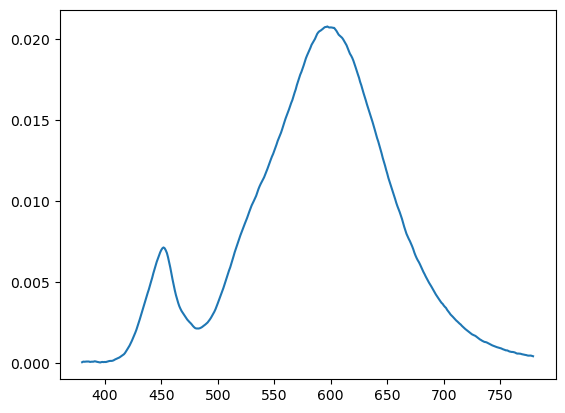

In [14]:
import matplotlib.pyplot as plt

wavelengths = np.arange(380, 780, 1)

plt.plot(wavelengths, D_data[:,1000])

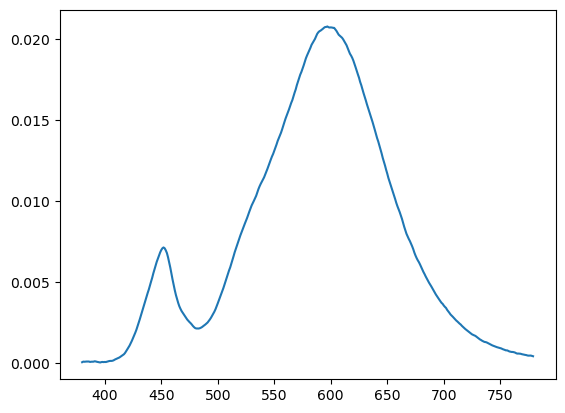

In [15]:
plt.plot(wavelengths, data[:,1000])